# Survey area vs cadence 

There is an inherent tension between the total area surveyed and the time interval between repeated visits to a single pointing (cadence). This issue is compounded if more than one filter is used.  

The goal of this notebook is to provide some rough guidance on this trade-off.  

In [5]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

The first information we need is the technical capabilities of the spacecraft.  The following constraints are taken from Goddard's [website of technical specifications](https://roman.gsfc.nasa.gov/science/WFI_technical.html) for the mission.  Much more detailed information is also available from the [mission's official documentation](https://roman-docs.stsci.edu/roman-instruments-home).  
Slew and settle times for example, are a function of angular distance to be traveled, so we can interpolate over the data provided.

Text(0, 0.5, 'Slew & settle time [s]')

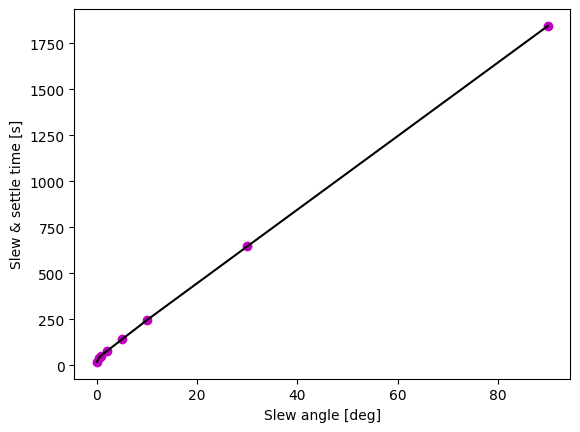

In [6]:
# Data from Roman's Technical Specifications
slew_data = np.array([
    [0.025, 18.9],
    [0.4, 39.3],
    [0.8, 52.5],
    [2.0, 77.8],
    [5.0, 141.0],
    [10.0, 246.0],
    [30.0, 646.0],
    [90.0, 1844.0]
])

# Create interpolated function
slew_func = interp1d(slew_data[:,0], slew_data[:,1])

slew_pred = slew_func(slew_data[:,0])

plt.plot(slew_data[:,0], slew_data[:,1], 'mo')
plt.plot(slew_data[:,0], slew_pred, 'k-')
plt.xlabel('Slew angle [deg]')
plt.ylabel('Slew & settle time [s]')

I looked for, but couldn't immediately find, the expected time taken to change filter, so here I make an educated guess. It may be that this can be performed during slews. 
In addition, integration times can be variable, but for the sake of estimation, I take the 57s integration time used to estimate imaging sensitivity in the resources above. 

In [7]:
filter_change_time = 30.0 # seconds
integration_time = 57.0 # seconds

The other constraint we have is the total number of hours available for the Galactic Plane Survey.

In [18]:
max_gps_time = 700.0 # hrs

## Single filter, wide-area + time-domain surveys

In this simulation, I assume that a visit to a single on-sky pointing consists of n_int integrations in a single filter.  

In [30]:
n_int = 1
n_filters = 1
visit_time = (filter_change_time + integration_time) * n_int
print('Time take for single visit to a single pointing = ' + str(visit_time) + 's')

Time take for single visit to a single pointing = 87.0s


In this simulation, the survey strategy will consist of two components: a wide-area continguous region within which all pointings will recieve n_wide_visits visits plus a smaller, contiguous time-domain region within which all pointings receive n_td_visits.

Firstly, we can calculate the time required to survey the wide-area footprint a minimum number of times.  

In [9]:
# A number of science cases recommended a minimum of 2 visits per pointing 
n_wide_visits = 2.0

# Since we assume that the survey region is contiguous, we can also assume that the telescope 
# will be able to slew from one field directly to next one over, meaning that the slew angular distance will 
# consistently be the approximate width of the Roman WFI field of view (here approximated as a circle).  
# So now we can calculate the slew time required
slew_ang_distance = 0.3 # degrees
slew_time = slew_func(slew_ang_distance)
print('Time to slew from one field to the next: ' + str(slew_time) + 's')

Time to slew from one field to the next: 33.86s


Using this information we can plot how much time it will take to survey different areas of wide-area survey.

In [13]:
def calc_npointings(survey_area):
    """
    Function estimates the expected number of individual field pointings within a survey footprint area, by simply dividing the 
    survey area by the WFI field of view.  Note that no account is taken of dithering.  
    """

    return np.rint(survey_area / 0.28)

Maximum feasible wide-area survey = 7020.738103448275 sq.deg


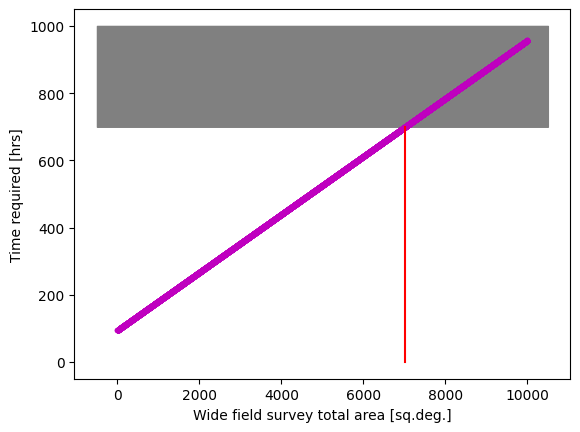

In [36]:
# Explore wide-area survey footprints of different sizes, and infer the number of pointings required
area = np.arange(1.0, 10000.0, 1.0)
npointings = calc_npointings(area)

# Estimate the time required to survey this many pointings in hours
survey_time = (npointings * visit_time + len(npointings)*slew_time) / 3600.0

# Interpolate and project the maximum possible survey area within the maximum allowed time for the GPS
survey_area_func = interp1d(survey_time, area)
max_survey_area = survey_area_func(max_gps_time)
print('Maximum feasible wide-area survey = ' + str(max_survey_area) + ' sq.deg')

plt.plot(area, survey_time, 'm.')
plt.xlabel('Wide field survey total area [sq.deg.]')
plt.ylabel('Time required [hrs]')
[xmin, xmax, ymin, ymax] = plt.axis()
x = np.arange(xmin, xmax, 1.0)
plt.fill_between(x, [max_gps_time]*len(x), y2=[ymax]*len(x), color='grey')
plt.plot([max_survey_area, max_survey_area], [0, max_gps_time], 'r-')

Now we can think about carving out a subregion for a time domain survey.  Obviously, the larger this region is and the more often the visits to this area, the smaller the area of the wide-field survey becomes.  

The next goal is to get a sense for the trade offs between time domain survey area, cadence and wide-field region. 

In [37]:
def calc_time_domain_survey_time_alloc(td_area, n_td_visits, td_visit_time, slew_time):
    """
    Function to estimate the time required for a time domain survey of td_area total area in sq.deg. with n_td_visits per pointing, 
    and taking td_visit_time for each visit.  We assume a contiguous survey region, so slew times can be assumed to be 
    constant - note that this doesn't take into account the need to slew between the time domain and wide area survey regions.
    """

    # Calculate the total number of pointings required
    n_td_pointings = calc_npointings(td_area)

    # Calculate total survey time in hours
    td_survey_time = (npointings * td_visit_time + len(n_td_pointings)*slew_time) / 3600.0

    return td_survey_time

Setting the configuration for the time domain survey strategy...

In [38]:
# The number of visits per field is a proxy for cadence, so let's explore a range
n_td_visits = np.arange(2.0, 100.0, 1.0)

# The total area that we'd like to include in this survey is the other factor to be explored [sq.deg.]
td_area = np.arange(1.0, 100.0, 1.0)

# We assume that the survey region is contiguous, with a consistent slew time between fields. 
# Note that this neglects the additional slew time necessary to switch between time-domain and wide-area fields.
slew_ang_distance = 0.3 # degrees
slew_time = slew_func(slew_ang_distance)

# The duration of a single visit to a time domain survey field, taking the number of filters used and integration time 
# into account
n_int = 1
n_filters = 1
td_visit_time = (filter_change_time + integration_time) * n_int

In [40]:
# Calculate survey time taken for the ranges of numbers of visits and survey area 
td_survey_time = calc_time_domain_survey_time_alloc(td_area, n_td_visits, td_visit_time, slew_time)
print(td_survey_time.shape)

(9999,)
